# Interpretabilidade de modelos

Nas próximas duas aulas vamos explorar os seguintes tópicos em Python:

- 1) Interpretabilidade de modelos
- 2) Modelos naturalmente interpretáveis
- 3) LIME
- 4) SHAP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

____
____
____

## Parte 1
## 1) Interpretabilidade de modelos

Nesta altura, já entendemos bem **o que** é um modelo, e como podemos construir modelos dos mais variados tipos.

Muitas vezes, no entanto, é de interesse que os modelos criados sejam **interpretáveis**, isto é, que seja possível **analisarmos por que o target $\hat{y}$ foi produzido pelo modelo**.

A necessidade ou não de interpretabilidade de modelos depende, muitas vezes, do problema de negócio específico. Pode haver certos problemas em que o objetivo é que tenhamos o modelo **com a melhor performance possível**, sem que haja necessidade de interpretarmos **o que** o modelos está fazendo. Se este for o caso, somos completamente livres para utilizar qualquer técnica que desejarmos, visando sempre aumentar a performance do modelo.

Em outros casos, no entanto, performance máxima não é o único objetivo: é necessário que os modelos produzidos também sejam interpretáveis, por diversos motivos, a citar alguns:

- Necessidade de extração de insights estratégicos a partir das estruturas aprendidas;
- Obrigação regulatória de interpretabilidade;
- Necessidade de adequação à regras de negócio particulares

Portanto, se interpretabiliade for uma questão importante, é importante que guiemos a construção de nossos modelos com este objetivo em mente. Para isso, há, essencialmente, duas abordagens possíveis:

> **Criar modelos naturalmente interpretáveis**: há modelos (que já conhecemos!), que são facilmente interpretáveis, devido à estrutura particular da hipótese. Assim, se interpretabilidade for algo importante, escolher estas hipóteses pode ser uma boa alternativa. 
<br><br>
No entanto, um ponto importantíssimo a ser considerado é que **há alguns procedimentos de pré-processamento** que podem obscurecer esta interpretabilidade natural (por exemplo: scalers, PCA, etc.). 
<br><br>
Portanto, se interpretabilidade de fato for uma questão, é muito importante que atenção seja tomada **até mesmo no pré-processamento** dos dados, mesmo que isso possa comprometer parte da performance do modelo;

> **Aplicar alguma técnica de explicabilidade de modelos**: se a busca por interpretabilidade acabar comprometendo muito a perfromance, é possível que sigamos com modelos que não sejam naturalmente interpretáveis, mas que possam ser interpretados por técnicas específicas que buscam interpretabilidade. Vamos estudar estas técnicas hoje!

Antes de mergulharmos neste assunto, um último comentário: a questão de interpretabilidade de modelos de ML é de extremo interesse pela comunidade científica, e cada vez mais tem ganhado espaço no mundo corporativo. De maneira mais geral, esta área é conhecida como [Explainable AI](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence), e há grande esforço na direção de tornar AI uma área interpretável, o que leva a discussões bem fundamentais sobre estas tecnologias. Para quem se interessar, sugiro algumas leituras: [aqui, da IBM](https://www.ibm.com/watson/explainable-ai); [e aqui, do Google](https://cloud.google.com/explainable-ai).

E para quem realmente quiser mergulhar neste assunto, sugiro [este livro!](https://christophm.github.io/interpretable-ml-book/)

Agora, vamos detalhar um pouco mais as duas abordagens descritas acima!

____
____
____

## 2) Modelos naturalmente interpretáveis

Conforme discutimos acima, há modelos que são naturalmente explicáveis. Vamos discutir alguns deles:

____________

### Regressão Linear

O primeiro modelo que construímos no curso, foi um modelo de regressão linear para o preço de casas, com base em uma única variável:

> O nosso modelo final é dado por:
<br><br>
$$ y = f_H(x) =  1562.01 + 118.61\text{GrLiveArea}$$
<br><br>
Isto quer dizer que:
<br><br>
Aumentando a variável "GrLiveArea" em uma unidade faz com que o preço seja aumentado em USD 118.6!
<br><br>
O preço mínimo a ser pago, independente da área construída, é de 1562.01!

Mas mesmo modelos de regressão linear múltipla são interpretáveis! A hipótese é dada por:

$$ y = f_H(\vec{x}) = b_0 + \sum_{i=1}^n b_i X_i = b_0 + b_1 X_1 + b_2 X_2 + \cdots + b_n X_n $$

A interpretabilidade também é direta:

> Aumentando uma unidade da feature $X_i$, temos que o preço aumenta/diminui em $b_i$ unidades (a depender do sinal do coeficiente);
<br><br>
O preço fixo sempre é $b_0$.

Note, portanto, que simplesmente ao olharmos para os parâmetros da hipótese (`.coef_` e `.intercept_`), temos informações concretas e claríssimas sobre o modo como cada feature é utilizada para, conjuntamente, predizer o target. Esse é o mais simples exemplo de interpretabilidade!

**Observação**: também podemos olhar para o "tamanho" dos coeficientes para entender quais features são "mais importantes": coeficientes maiores (em valor absoluto) estão associados a "maior peso" na determinação do target. 

No entanto, a escala das features interfere nesta análise! Features com escala maior tendem a proporcionar coeficientes menores, e vice-versa. Por isso, se o objetivo é inspecionar importância de features na regressão linear, é importante que os dados sejam previamente escalados! [Este post](https://towardsdatascience.com/feature-importance-in-linear-models-four-often-neglected-but-crucial-pitfalls-e5c513e45b18) discute este ponto brevemente.

____________

### Árvores

Árvores são modelos naturalmente interpretáveis também: podemos inspecionar **o caminho que cada observação percorre do nó raiz até a folha** para entender exatamente qual foi o critério para a decisão, nó a nó!

Podemos inspecionar este caminho olhando para uma árvore plotada, ou então utilizando o método [decision_path!](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.decision_path) Vamos ver um exemplo rápido:

In [3]:
from sklearn.datasets import load_iris
X, y = load_iris(as_frame=True, return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
X_train

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
8,4.4,2.9,1.4,0.2
106,4.9,2.5,4.5,1.7
76,6.8,2.8,4.8,1.4
9,4.9,3.1,1.5,0.1
89,5.5,2.5,4.0,1.3
...,...,...,...,...
37,4.9,3.6,1.4,0.1
2,4.7,3.2,1.3,0.2
33,5.5,4.2,1.4,0.2
52,6.9,3.1,4.9,1.5


In [5]:
y_train

8      0
106    2
76     1
9      0
89     1
      ..
37     0
2      0
33     0
52     1
3      0
Name: target, Length: 120, dtype: int32

In [6]:
# y_train
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 40, 1: 40, 2: 40}

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


Métricas de avaliação de treino:


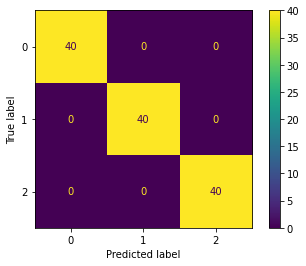

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120


Métricas de avaliação de teste:


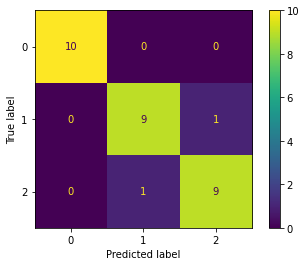

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [8]:
# treinar o modelo
tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# Avaliação do modelo
metricas_classificacao(tree, X_train, X_test, y_train, y_test)

In [9]:
tree.get_depth()

5

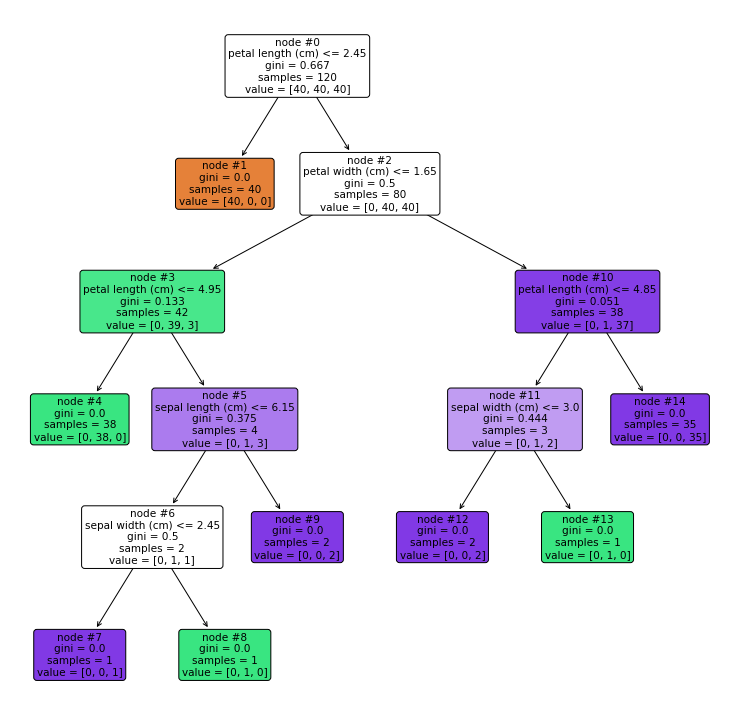

In [15]:
plt.subplots(1, 1, figsize=(13, 13))

plot_tree(tree, feature_names=tree.feature_names_in_, filled=True, rounded=True, node_ids=True)
plt.show()

In [16]:
dec_path = tree.decision_path(X_test).toarray()

In [17]:
X_test.iloc[[0]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
38,4.4,3.0,1.3,0.2


In [18]:
dec_path[0]

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [19]:
y_test.iloc[[0]]

38    0
Name: target, dtype: int32

In [20]:
X_test.iloc[[21]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
140,6.7,3.1,5.6,2.4


In [21]:
dec_path[21]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int64)

In [22]:
y_test.iloc[[21]]

140    2
Name: target, dtype: int32

In [23]:
tree.predict(X_test)[21]

2

Para saber mais, como se aproveitar dessas estruturas, [clique aqui!](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)

Adaptando o código da página acima, podemos construir uma função para interpretar a árvore:

In [24]:
tree.feature_names_in_

array(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'], dtype=object)

In [25]:
tree.tree_.feature

array([ 2, -2,  3,  2, -2,  0,  1, -2, -2, -2,  2,  1, -2, -2, -2],
      dtype=int64)

In [26]:
tree.tree_.threshold

array([ 2.44999999, -2.        ,  1.65000004,  4.95000005, -2.        ,
        6.1500001 ,  2.45000005, -2.        , -2.        , -2.        ,
        4.85000014,  3.        , -2.        , -2.        , -2.        ])

In [27]:
def interpreta_arvore(tree, X_test, idx):
    
    node_indicator = tree.decision_path(X_test)
    leaf_id = tree.apply(X_test)
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold

    node_index = node_indicator.indices[node_indicator.indptr[idx] : node_indicator.indptr[idx + 1]]
    
    print(f"{idx+1}a observação de teste:")
    display(X_test.iloc[[idx]])

    print("="*50)
    print("Regras utilizada em cada nó percorrido da árvore:\n")

    feature_names = tree.feature_names_in_
    
    for node_id in node_index:

        # continue to the next node if it is a leaf node
        if leaf_id[idx] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_test.iloc[idx][feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        
        print("Nó de decisão {node} : ({feature_name} = {value}) "
              "{inequality} {threshold:.2f})".format(node=node_id,
                                                     feature_name=feature_names[feature[node_id]],
                                                     value=X_test.iloc[idx][feature[node_id]],
                                                     inequality=threshold_sign,
                                                     threshold=threshold[node_id]))
        
    y_pred = tree.predict(X_test)[idx]
    print("="*50)
    print(f"Predição na folha: y = {y_pred}")

In [28]:
for i in range(5):
    interpreta_arvore(tree, X_test, i)
    
    print("\n", "#"*80, "\n")

1a observação de teste:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
38,4.4,3.0,1.3,0.2


Regras utilizada em cada nó percorrido da árvore:

Nó de decisão 0 : (petal length (cm) = 1.3) <= 2.45)
Predição na folha: y = 0

 ################################################################################ 

2a observação de teste:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
127,6.1,3.0,4.9,1.8


Regras utilizada em cada nó percorrido da árvore:

Nó de decisão 0 : (petal length (cm) = 4.9) > 2.45)
Nó de decisão 2 : (petal width (cm) = 1.8) > 1.65)
Nó de decisão 10 : (petal length (cm) = 4.9) > 4.85)
Predição na folha: y = 2

 ################################################################################ 

3a observação de teste:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
57,4.9,2.4,3.3,1.0


Regras utilizada em cada nó percorrido da árvore:

Nó de decisão 0 : (petal length (cm) = 3.3) > 2.45)
Nó de decisão 2 : (petal width (cm) = 1.0) <= 1.65)
Nó de decisão 3 : (petal length (cm) = 3.3) <= 4.95)
Predição na folha: y = 1

 ################################################################################ 

4a observação de teste:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
93,5.0,2.3,3.3,1.0


Regras utilizada em cada nó percorrido da árvore:

Nó de decisão 0 : (petal length (cm) = 3.3) > 2.45)
Nó de decisão 2 : (petal width (cm) = 1.0) <= 1.65)
Nó de decisão 3 : (petal length (cm) = 3.3) <= 4.95)
Predição na folha: y = 1

 ################################################################################ 

5a observação de teste:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
42,4.4,3.2,1.3,0.2


Regras utilizada em cada nó percorrido da árvore:

Nó de decisão 0 : (petal length (cm) = 1.3) <= 2.45)
Predição na folha: y = 0

 ################################################################################ 



____________

### KNN

Modelos KNN também são interpretáveis, em certa medida, pois podemos **olhar para os vizinhos que foram levados em conta pra tomar a decisão**, e com isso, podemos comparar estes vizinhos com a observação de teste, e, assim, interpretar a decisão!

Fazemos isso com o método [kneighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors). Vamos ver um exemplo:

In [29]:
from sklearn.neighbors import KNeighborsClassifier


Métricas de avaliação de treino:


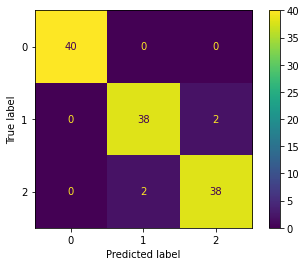

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      0.95      0.95        40
           2       0.95      0.95      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120


Métricas de avaliação de teste:


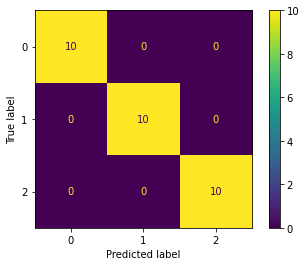

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [30]:
knn = KNeighborsClassifier().fit(X_train, y_train)

metricas_classificacao(knn, X_train, X_test, y_train, y_test)

Utilizando o método `.kneighbors()`, vamos obter qual a distância e quem são os k vizinhos mais próximos na classificação do X_test:

In [31]:
dist_k, idcs_k = knn.kneighbors(X_test)

Vamos olhar, por exemplo, apenas para a primeira observação:

In [32]:
X_test.iloc[[0]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
38,4.4,3.0,1.3,0.2


Qual a distância dos vizinhos mais próximos?

In [33]:
dist_k[0]

array([0.14142136, 0.24494897, 0.3       , 0.3       , 0.36055513])

Quais os índices dos k vizinhos mais próximos?

In [34]:
idcs_k[0]

array([  0,  93, 119,  58, 116], dtype=int64)

Podemos usar os índices para inspecionar quais foram as observações utilizadas do X_train na classificação:

In [35]:
# cuidado: temos que usar o iloc, pq os idcs_k são as POSIÇÕES ordinais das observações,
# não os indices do pandas!!

X_train.iloc[idcs_k[0]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
8,4.4,2.9,1.4,0.2
13,4.3,3.0,1.1,0.1
3,4.6,3.1,1.5,0.2
47,4.6,3.2,1.4,0.2
2,4.7,3.2,1.3,0.2


In [36]:
X_train.iloc[idcs_k[0]].describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,5.000000,5.000000,5.000000,5.000000
mean,4.520000,3.080000,1.340000,0.180000
std,0.164317,0.130384,0.151658,0.044721
min,4.300000,2.900000,1.100000,0.100000
25%,4.400000,3.000000,1.300000,0.200000
50%,4.600000,3.100000,1.400000,0.200000
75%,4.600000,3.200000,1.400000,0.200000
max,4.700000,3.200000,1.500000,0.200000


Quais eram as classes desses k vizinhos mais próximos?

In [37]:
y_train.iloc[idcs_k[0]]

8     0
13    0
3     0
47    0
2     0
Name: target, dtype: int32

Faz sentido, pois se dermos um predict nesse ponto temos:

In [38]:
knn.predict(X_test)[0]

0

In [39]:
knn.predict_proba(X_test)[0]

array([1., 0., 0.])

Vamos criar uma função:

In [40]:
def interpreta_knn(knn, X_train, y_train, X_test, idx):
    
    print(f"{idx+1}a observação de teste:")
    display(X_test.iloc[[idx]])
    
    dist_k, indices_k = knn.kneighbors(X_test)

    print("="*50)
    print(f"Número de vizinhos utilizados na classificação: {knn.n_neighbors}\n")
    
    print(f"Distância entre observação de teste e cada vizinho:\n{np.round(dist_k[idx], 3)}\n")
    
    print(f"Vizinhos utilizados, e respectivo target:")
    display(pd.concat([X_train.iloc[indices_k[idx]], y_train.iloc[indices_k[idx]]], axis=1))
    
    print("="*50)
    print("Probas de cada classe:")
    display(pd.DataFrame({"probas":knn.predict_proba(X_test)[idx]}, index=knn.classes_).T)
    
    print(f"Classe final predita: {knn.predict(X_test)[idx]}")

In [41]:
for i in range(3):
    interpreta_knn(knn, X_train, y_train, 
                   X_test, idx=i)
    
    print("\n","#"*80, "\n")

1a observação de teste:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
38,4.4,3.0,1.3,0.2


Número de vizinhos utilizados na classificação: 5

Distância entre observação de teste e cada vizinho:
[0.141 0.245 0.3   0.3   0.361]

Vizinhos utilizados, e respectivo target:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
8,4.4,2.9,1.4,0.2,0
13,4.3,3.0,1.1,0.1,0
3,4.6,3.1,1.5,0.2,0
47,4.6,3.2,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


Probas de cada classe:


,0,1,2
probas,1.0,0.0,0.0


Classe final predita: 0

 ################################################################################ 

2a observação de teste:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
127,6.1,3.0,4.9,1.8


Número de vizinhos utilizados na classificação: 5

Distância entre observação de teste e cada vizinho:
[0.245 0.283 0.3   0.361 0.424]

Vizinhos utilizados, e respectivo target:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
126,6.2,2.8,4.8,1.8,2
149,5.9,3.0,5.1,1.8,2
70,5.9,3.2,4.8,1.8,1
123,6.3,2.7,4.9,1.8,2
83,6.0,2.7,5.1,1.6,1


Probas de cada classe:


,0,1,2
probas,0.0,0.4,0.6


Classe final predita: 2

 ################################################################################ 

3a observação de teste:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
57,4.9,2.4,3.3,1.0


Número de vizinhos utilizados na classificação: 5

Distância entre observação de teste e cada vizinho:
[0.387 0.458 0.721 0.787 0.837]

Vizinhos utilizados, e respectivo target:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
98,5.1,2.5,3.0,1.1,1
60,5.0,2.0,3.5,1.0,1
81,5.5,2.4,3.7,1.0,1
80,5.5,2.4,3.8,1.1,1
59,5.2,2.7,3.9,1.4,1


Probas de cada classe:


,0,1,2
probas,0.0,1.0,0.0


Classe final predita: 1

 ################################################################################ 



_____
_____

## Parte 2
O que fazemos no caso em que não é praticável utilizarmos alguns dos modelos mais simples e interpretáveis acima?

Nestes casos, o que vamos querer fazer é **treinar um modelo simples $g$** que seja capaz de **explicar um modelo complexo $f$**. Diremos então que $g$ é o **modelo explicativo** de $f$!

Veremos como fazer isso agora!

____
____

## 3) LIME

O LIME (**L**ocal **I**nterpretable **M**odel-agnostic **E**xplanations) é uma técnica que nos permite gerar modelos explicativos $g$ que são treinados **localmente** com o objetivo de explicar um modelo complexo $f$!

Considere o classificador à esquerda, que é o modelo original ($f$). Note a fronteira de decisão não-linear, que é um indicativo de dificuldade de explicabilidade. Caso queiramos explicar este modelo globalmente, teremos dificuldades, justo? (De fato, fronteiras de decisão não-lineares são dificilmente explicáveis!)

Por outro lado, **localmente**, em regiões próximas à fronteira de decisão, é possível **aproximarmos $f$ pelo modelo simples $g$, que é linear**. 

Com isso, **localmente**, fica fácil de explicar a decisão, com o modelo representado à direita!

<img src=https://deepandshallowml.files.wordpress.com/2019/11/lime_intuition_final.png width=600>

Os modelos lineares locais treinados pelo LIME também são conhecidos como surrogate models e seu treinamento funciona da seguinte maneira:

- Um novo dataset de observações artificiais é criado (dados permutados), com base na distribuição das features na redondeza da observação a ser explicada;

- A distância entre estas observações e as observações reais são calculadas;

- O modelo é utilizado para predizer o `predict_proba` para estas novas observações;

- Escolhe-se as `m` features mais importantes, de acordo com os dados permutados;

- Um modelo linear é treinado com as `m` features, ponderando a similaridade entre samples (amostras) e a observação a ser explicada.

O artigo original do LIME está disponível [aqui](https://arxiv.org/pdf/1602.04938.pdf) -- e ele é (talvez surpreendentemente) simples de ler!

E [neste post](https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5) há mais detalhes sobre o LIME e seu funcionamento!

Aqui, vamos ver, na prática, como aplicar o LIME!

Pra isso, existe a biblioteca [LIME](https://github.com/marcotcr/lime). Para instala-la:

`!pip install lime`
ou
`conda install -c conda-forge lime`

Vamos vê-la em ação!

Vamos construir um modelo bem mais complexo, para que faça sentido aplicarmos técnicas de explicabilidade!

Vamos utilizar o dataset do German Credit Data pra isso.

Nesse conjunto de dados, cada entrada representa uma pessoa que recebe um crédito de um banco. Cada pessoa é classificada como risco de crédito bom ou ruim de acordo com o conjunto de atributos. 

Informações das features:

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (text, Conta corrente - little, moderate, nan, rich)
- Credit amount (numeric, in Deutsch Mark)
- Duration (numeric, Duration of the loan in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [44]:
# df = pd.read_csv("../data/bank-full.csv") 
df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [45]:
df['Saving accounts'].value_counts()

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [46]:
df['Saving accounts'].isna().sum()

183

In [47]:
df.shape

(1000, 10)

In [48]:
#### Separar feature e target
# y = df['Target'].copy()
# X = df.drop(['Target', 'duration'], axis=1).copy()

# Vou dropar os nans no 'Saving accounts'
df = df.dropna(subset='Saving accounts')

y = df['Risk'].copy()
X = df.drop(['Risk'], axis=1).copy()

y = np.where(y=='good', 0, 1) #onde está escrito "good" vamos trocar por 0 e caso contrário preenchemos com 1

X = X[['Age', 'Saving accounts', 'Credit amount', 'Duration', 'Sex']].copy()

X = pd.get_dummies(X, columns=['Saving accounts', 'Sex'], drop_first=False)

#### particionar dados
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) 

In [49]:
X.head()

,Age,Credit amount,Duration,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Sex_female,Sex_male
1,22,5951,48,1,0,0,0,1,0
2,49,2096,12,1,0,0,0,0,1
3,45,7882,42,1,0,0,0,0,1
4,53,4870,24,1,0,0,0,0,1
6,53,2835,24,0,0,1,0,0,1


In [ ]:
# from sklearn.datasets import load_breast_cancer
# X, y = load_breast_cancer(return_X_y=True, as_frame=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Métricas de avaliação de treino:


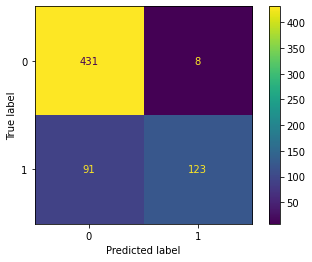

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       439
           1       0.94      0.57      0.71       214

    accuracy                           0.85       653
   macro avg       0.88      0.78      0.81       653
weighted avg       0.86      0.85      0.84       653


Métricas de avaliação de teste:


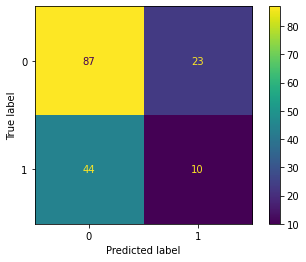

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       110
           1       0.30      0.19      0.23        54

    accuracy                           0.59       164
   macro avg       0.48      0.49      0.48       164
weighted avg       0.55      0.59      0.56       164



In [50]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier().fit(X_train, y_train) # treinando o modelo

metricas_classificacao(gb, X_train, X_test, y_train, y_test) # avaliar o modelo

No [LIME](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular) precisamos passar os valores do X_train como um array

In [57]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(X_train.values, # array - X_train é um datafram, X_train.values é um array
                                              mode="classification", # classificação
                                              feature_names=gb.feature_names_in_, #nome das features
                                              class_names=gb.classes_, #nome das classes
                                              random_state=42)

In [58]:
X_test.iloc[[0]]

,Age,Credit amount,Duration,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Sex_female,Sex_male
518,43,1203,6,0,1,0,0,0,1


In [59]:
# a interpretação muda a cada observação
explanation = explainer.explain_instance(X_test.iloc[0], # explicar o modelo a partir da observação. 
                                         gb.predict_proba,
                                         num_features=gb.n_features_in_)

explanation.show_in_notebook()

Acima, visualizamos o resultado do explainer!

O plot no centro é a principal informação para a interpretabilidade: ele exibe o valor dos coeficientes do modelo linear treinado localmente.

Importante: para o treinamento do modelo linear, as features numéricas são discretizadas em bins, cujos intervalos são indicados no plot.

As features são exibidas em ordem de importância, e é assim que somos capazes de descrever quais foram as features mais importantes na tomada de decisão, observação a observação!

Mudando a observação a ser explicada: a interpretação muda!

In [60]:
X_test.iloc[[7]]

,Age,Credit amount,Duration,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Sex_female,Sex_male
57,31,9566,36,1,0,0,0,1,0


In [61]:
explanation = explainer.explain_instance(X_test.iloc[7],
                                         gb.predict_proba,
                                         num_features=gb.n_features_in_)

explanation.show_in_notebook()

Resumo do que fizemos:

Pegamos um modelo complexo, que aprendeu padrões não lineares nos dados, e o dividimos em vários modelos lineares que descrevem pontos de dados individuais através de coeficientes $ϕ$. Lembrando que esses coeficientes de explicação $ϕ$ não são a saída do modelo, mas sim o que estamos usando para interpretar o modelo e eles serão diferentes para cada ponto analisado. Ao agregar todos esses modelos simples e individuais, podemos entender como o modelo complexo se comporta em todos os pontos.

Assim, em vez de tentar explicar todo o modelo complexo, tentamos explicar como o modelo complexo se comportou para um ponto de dados usando um modelo de explicação linear o qual chamamos de $g$.

____
____
____

## 4) SHAP

Por fim, vamos dar uma olhada no SHAP (**SH**apley **A**dditive ex**P**lanation), um outro método muito utilizado para interpretabilidade.

<img src=https://shap.readthedocs.io/en/latest/_images/shap_header.png width=700 />

o SHAP é um método baseado em um conceito de [teoria dos jogos](https://pt.wikipedia.org/wiki/Teoria_dos_jogos) conhecido como [Shapley values](https://christophm.github.io/interpretable-ml-book/shapley.html).

A ideia geral do método é encontrar **a importância das features para a predição** de modo bem explícito: para encontrar a importância de uma feature $x_i$, temos que:

- Treinar o modelo $f$ com todos os **subconjuntos possíveis** de features, **incluindo $x_i$**;
- Depois treinar o modelo $f$ com os mesmos subconjuntos, mas **excluindo $x_i$**.
- Depois, medimos a diferença entre os outputs de cada par de modelos.

Com a diferença entre os outputs, nós conseguimos medir **o impacto** da remoção daquela feature no output. Tomando uma espécie de **média** deste impacto dentre todos os subconjuntos, conseguimos ter a importância geral de $x_i$!

Obs.: o operacional do método é similar ao RFE, com a diferença de que aqui consideramos **todos** os subconjuntos com e sem a feature $x_i$!

Exemplo de subconjuntos:

Considere que temos as features $\vec{x} = (x_1, x_2, x_3, x_4)$, e que queremos estimar o impacto da feature $x_1$. 

Os subconjuntos possíveis **que incluem** $x_1$ são:

$ \{x_1\}$

$ \{x_1, x_2\}$

$ \{x_1, x_3\}$

$ \{x_1, x_4\}$

$ \{x_1, x_2, x_3\}$

$ \{x_1, x_2, x_4\}$

$ \{x_1, x_3, x_4\}$

$ \{x_1, x_2, x_3, x_4\}$

Os subconjuntos possíveis **que não incluem** $x_1$ são:

$ \{ \}$ (null model - é uma simples média do target)

$ \{x_2\}$

$ \{x_3\}$

$ \{x_4\}$

$ \{x_2, x_3\}$

$ \{x_2, x_4\}$

$ \{x_3, x_4\}$

$ \{x_2, x_3, x_4\}$

Note, portanto, que treinamos **16 modelos diferentes** para avaliar a importância de $x_1$

> No geral, para $n$ features, temos $2 \times 2^{n-1} = 2^n$ modelos diferentes que devem ser treinados para inspecionar a importância de cada feature, ou seja, $n \times 2^n$ modelos no total!

Portanto, fica claro que a utilização de Shapley values para a interpretação de modelos é algo **computacionalmente extremamente custoso**. 

É pensando nisso que o método SHAP vem à nossa salvação! :D

O artigo original do SHAP está [aqui](https://arxiv.org/pdf/1705.07874.pdf) -- esse é um pouquinho mais difícil, mas também é relativamente acessível!

E [neste post](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30) há detalhes interessantes sobre o funcionamento do SHAP!

> Interlúdio matemático (conceitual): conforme dissemos, o SHAP é um método baseado em conceitos de teoria de jogos. Nesta teoria, há dois agentes muito importantes: **o jogo** e **os jogadores**. No contexto de interpretabilidade de ML, temos:
<br>
- Os outputs do modelo como o jogo;
<br><br>
- Os jogadores como as features a serem incluídas no modelo.
<br><br>
>A interação entre estes agentes é quantificada justamente pelo valor de Shapley. O que o SHAP faz é quantificar quanto cada feature está contribuindo na predição do modelo e para isso ele considera todas as combinações de features mencionadas acima para determinar qual a importância de uma única feature.

Acesse os links acima para detalhes! 

Em resumo: o Shapley calcula a importância de uma determinada feature comparando o que um modelo prediz com e sem ela, mas como a ordem em que o modelo vê as features pode impactar nas predições, o shap faz essa análise considerando todas as ordens possíveis. 

Considerando o dataset German Credit Risk, cada variável tem sua contribuição na predição final. Pode ser que uma pequna variação na idade traga uma predição completamente diferente, enquanto uma pequena variação na renda da pessoa não tenha um efeito tão significativo.


Agora vamos ver, na prática, como aplicar o [SHAP](https://shap.readthedocs.io/en/latest/index.html). Para instalar a lib faça:

`!pip install shap`
ou
`conda install -c conda-forge shap`

Vamos vê-la em ação!

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier().fit(X_train, y_train)

In [ ]:
import shap

# Cria um objeto explainer
explainer = shap.Explainer(gb, X_train)

# Calcula o valor de SHAP para cada observação da matrix X_train.
# Será gerado um valor de SHAP para cada feature do nosso modelo.
shap_values = explainer(X_train)

#### Global Feature Importance: Beeswarm (Enxame de abelhas)
Neste primeiro gráfico temos a representação de todos os valores SHAP, os quais são agrupados pelas features no eixo y. Em cada um dos grupos temos os pontos rosa que indicam como altos valores daquela feature impactam na predição, enquanto pontos em azul indicam o impacto de valores baixos daquela feature. As features são ordenadas pelos valores médios de SHAP em ordem decrescente entre as mais importantes.

No eixo x temos os valores de SHAP que indicam quanto aquela observação afeta na mudança nas probabilidades de log (log-odds). Deste número podemos extrair a probabilidade de sucesso (1).

In [ ]:
shap.summary_plot(shap_values, X_train, max_display=20)

Como interpretamos o gráfico de beeswarm do SHAP?

- No eixo y temos as features, ordenadas por importância;

- À direita do valor zero em X representa um aumento na probabilidade de termos o target = 1, enquanto à esquerda do zero representa uma diminuição na probabilidade de termos o target = 1 (logo um aumento no target = 0)

- No eixo x temos os SHAP values -- valores positivos estão positivamente associados com o target, e vice-versa;

- Cada ponto é uma observação do dataset original;

- As cores estão associadas com o valor absoluto da respectiva feature pra cada observação;

- As observações são empilhadas para termos noção de densidade;

Como exemplo, vamos analisar a feature duration que indica o tempo total do empréstimo. Vemos que os pontos rosas, que indicam um duration maior, estão à direita do SHAP 0 e, por isso, concluímos que tem um impacto positivo no target (no caso, 1). Em outras palavras, durations maiores tem uma probabilidade maior de não pagar o empréstimo (risk). O contrário também é válido: durations menores tem um impacto negativo no target.

#### Global Feature Importance: Mean SHAP

Para cada feature é calculada a média dos valores absolutos de SHAP considerando todas as observações. Usamos os valores absolutos para que valores positivos e negativos não se compensem. No final, temos um gráfico parecido com o feature importance visto anteriormente.

Os números à direita do gráfico representam a média do SHAP para cada feature que nada mais é do que o efeito que essa feature na predição de risco de não pagar o empréstimo.

In [ ]:
shap.plots.bar(shap_values)

#### Local Feature Importance: Waterfall

A partir de agora vamos utilizar o SHAP para analisar como cada feature impacta em apenas uma observação. Vamos começar com o Waterfall (gráfico de cascata).

Os gráficos em cascata nos ajudam a visualizar quanto cada feature contribuiu (positivamente ou negativamente) para aquela predição quando comparado com o modelo baseline. Eles são projetados para exibir explicações para **previsões individuais**, portanto, eles esperam uma única linha de um objeto Explanation como entrada. 

A parte inferior de um gráfico em cascata começa com o valor esperado da saída do modelo baseline e, em seguida, cada linha mostra como a contribuição positiva (vermelha) ou negativa (azul) de cada recurso move o valor da saída do modelo.

In [ ]:
X_train.iloc[20:30]

In [ ]:
shap.plots.waterfall(shap_values[20])

Como ler o gráfico de waterfall
- O eixo x está em unidades de probabilidades logarítmicas (log-odds), portanto, valores negativos implicam em probabilidades inferiores a 0,5.
- O gráfico começa na parte inferior com a probabilidade do baseline. $E[f(x)]$ representa a média do valor predito desse baseline e no caso de classificação ele é apresentado em log odds (eixo x do gráfico). Dessa forma, os valores de SHAP que vemos aqui são todos relativos a essa predição média em log odds. Lembrando que:
$$log\_odds = \ln(\frac{p}{1-p})$$
- O gráfico mostra como a adição de cada feature muda a probabilidade de inadimplência para 1 ou 0. No fim, todas as features são consideradas, e a previsão final é mostrada no valor de $f(x)$.
- As features em vermelho são responsáveis por elevar a probabilidade de previsão acima do valor base, ou seja. aumenta a probabilidade de inadimplência.
- As features em azul são responsáveis por reduzir a previsão abaixo do valor base, ou seja. diminui a probabilidade de inadimplência.
- $f(x)$ é o valor final de predição para aquela observação. Ex: o credit amount aumenta em 0.95 o log odds da predição enquanto o age reduz em 0.38. Vamos fazer os histogramas do Credit amount e do Age para visualizarmos como essas features se comportam em relação ao risco.

[link](https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454)

In [ ]:
# Histograma do Credit amount separado pelo target
sns.histplot(data=X_train[y_train==0], x='Credit amount', label='No risk', color='yellow', binwidth=1000, binrange=[0,17000], kde=True, stat='density')
sns.histplot(data=X_train[y_train==1], x='Credit amount', label='Risk', binwidth=1000, binrange=[0,17000], kde=True, stat='density')
plt.legend()

Aqui vemos que o risco de inadimplência é menor para Credit amount menor que 4000. Em que local do gráfico está a observação 0 do gŕafico de waterfall acima? Faz sentido se compararmos com o valor do SHAP para essa feature?

In [ ]:
# Histograma do Age separado pelo target
sns.histplot(data=X_train[y_train==0], x='Age', label='No risk', color='yellow', binwidth=2, binrange=[15,85], kde=True, stat='density')
sns.histplot(data=X_train[y_train==1], x='Age', label='Risk', binwidth=2, binrange=[15,85], kde=True, stat='density')
plt.legend()

Nesse caso o risco de inadimplência é maior para idades abaixo de 30 anos e acima de 53 anos. Em que local do gráfico está a observação 0 do gŕafico de waterfall acima? Faz sentido se compararmos com o valor do SHAP para essa feature?

Aprofundamento:

Agora vamos entender um pouco melhor como são calculados o $E[f(x)]$ e o $f(x)$ e ver como convertê-los em probabilidades:


In [ ]:
# retorno do SHAP para a amostra 20
shap_values[20]

f(x), a predição da nossa amostra em log-odds, é a soma do valor do modelo baseline (E[f(x)]) com a soma das contribuições marginais de cada feature (dada por shap_values[0].values)
$$f(x) = E[f(x)] + valores\_SHAP$$
$$\ln(\frac{p}{1-p}) = E[\ln(\frac{p}{1-p})] + valores\_SHAP$$

In [ ]:
baseline = shap_values[20].base_values
f_x = baseline + shap_values[20].values.sum()
f_x

Vamos converter o f(x) de log odds para probabilidade e comparar com nosso valor predito

In [ ]:
import numpy as np
def logodds2prob(logit):
    odds = np.exp(logit)
    prob = odds / (1 + odds)
    return prob

print('Conversão do f(x) em probabilidade: ', logodds2prob(f_x))
print('Valor predito: ', gb.predict_proba(X_train.iloc[[20]]))

In [ ]:
shap_values[0]

#### Local Feature Importance: Barplot
O Barplot mostra basicamente a mesma informação que o waterfall, só muda a forma.

As barras em rosa representam features com impacto positivo no target e em azul impacto negativo.

Os números à direita do gráfico representam a média do SHAP para cada feature que nada mais é do que o efeito que essa feature tem na predição de risco de não pagar o empréstimo.

In [ ]:
shap.plots.bar(shap_values[20])

#### Local Feature Importance: Forceplot
O Forceplot mostra basicamente a mesma informação que o waterfall, só muda a forma.

In [ ]:
# Forceplot for first observation
shap.initjs()
shap.plots.force(shap_values[20])

Como interpretar o Forcebar:
- O baseline é o threshold.
- A direção mostra para onde cada feature está conduzindo a predição em relação ao valor base.
- As features vermelhos estão tentando empurrar os valores de previsão acima do valor base, indicando alto risco de inadimplência
- As features azuis estão tentando empurrar a previsão abaixo do valor base, indicando baixo risco de inadimplência

E para regressão como fica? Exercício para casa! Use o dataset abaixo e escolha um modelo de sua preferência para fazer as análises de interpretabilidade.

In [ ]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

____
____
____

## Bibliografia e aprofundamento
- [SHAP em modelo de regressão e outros gráficos](https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454)
- [Analisando interações entre features com SHAP](https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a)
- [SHAP: Decision Plot](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html)
- [SHAP: Heatmap Plot](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/heatmap.html)
- [Advanced Uses of SHAP Values](https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values/tutorial)
- [SHAP](https://www.analyticsvidhya.com/blog/2022/01/build-a-trustworthy-model-with-explainable-ai/)
- [Introduction to shap with python](https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454)
- [Interpreting complex models with shap values](https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83)

____
____
____